In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import warnings
from string import ascii_lowercase
# from qiskit.algorithms import NumPyMinimumEigensolver

%matplotlib widget

In [4]:
def add_labels(axs, positions=None, letters=None, fontsize=11, initial_parenthesis=True):
    if positions is None:
        positions = [[-0.1, 1.1]] * len(axs)
    else:
        if type(positions[0]) != 'list':
            positions = [positions] * len(axs)

    if letters is None:
        letters = []
        for i in range(len(axs)):
            letters.append(ascii_lowercase[i])

    if initial_parenthesis:
        initial = '('
    else:
        initial = ''

    for i in range(len(axs)):
        ax = axs[i]
        ax.text(positions[i][0], positions[i][1], initial + letters[i] + ')', horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

# $H_20$ grouping vs $x$ (w/ shuffle)

In [2]:
file = 'H20_grouping_shuffle_ideal_vs_connectivity'
data = np.load(file + '.npy', allow_pickle=True).item()

print(data.keys())

for key in data:
    vars()[key] = data[key]

dict_keys(['x_vec', 'n_groups', 'optimal_order_paulis', 'optimal_order_qubits', 'optimal_graph'])


In [3]:
n_x = len(x_vec)

n_std = np.zeros(n_x)
n_avg = np.zeros(n_x)
n_min = np.zeros(n_x)
n_max = np.zeros(n_x)

for i in range(n_x):
    n_std[i] = np.std(n_groups[i])
    n_avg[i] = np.mean(n_groups[i])
    n_min[i] = np.min(n_groups[i])
    n_max[i] = np.max(n_groups[i])

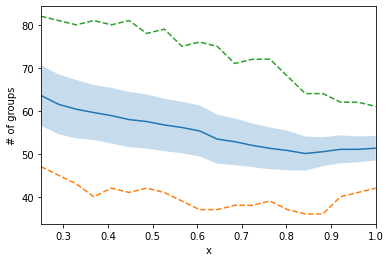

In [4]:
fig, ax = plt.subplots()
ax.plot(x_vec, n_avg)
ax.fill_between(x_vec, n_avg - n_std, n_avg + n_std, alpha=0.25)
ax.plot(x_vec, n_min, '--')
ax.plot(x_vec, n_max, '--')
ax.set_xlabel('x')
ax.set_ylabel('# of groups')
ax.set_xlim([x_vec[0], x_vec[-1]]);

In [5]:
index_min = np.argmin(n_min)
print('The minumum number of groups is {:.0f}, obtained for x = {:.3f}'.format(n_min[index_min], x_vec[index_min]))

The minumum number of groups is 36, obtained for x = 0.842


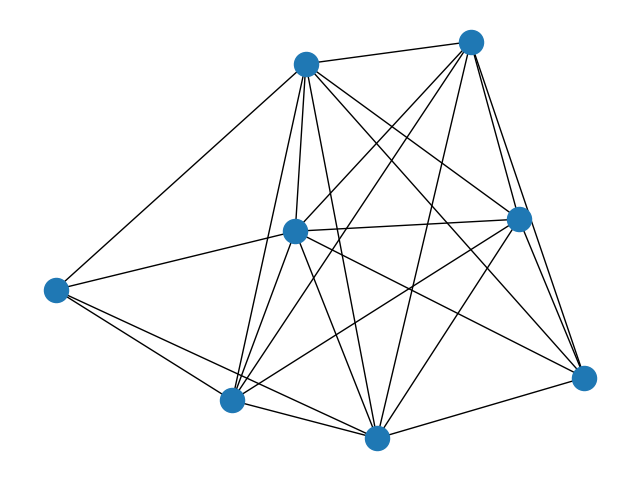

In [14]:
plt.figure()
nx.draw(optimal_graph[index_min])

# Optimal VQE

## Simulation

In [53]:
molecule = 'H2O'
name_backend = 'ibmq_montreal'

noise = True
file_name = 'VQE_'
if not noise:
    file_name += 'noise_free_'
    
data_sim = np.load('../data/' + file_name + molecule + '_' + name_backend + '.npy', allow_pickle=True).item()

data_qubit_op = np.load('../data/optimal_grouping_' + molecule + '_' + name_backend + '.npy', allow_pickle=True).item()
qubit_op = data_qubit_op['qubit_op']
num_qubits = qubit_op.num_qubits

groupings = ['TPB', 'EM', 'HEEM']
n_groups = {}
for grouping in groupings:
    n_groups[grouping] = data_qubit_op[grouping]['n_min']

result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
print('The exact energy is: {:.3f}'.format(np.real(result_exact.eigenvalue)))

print('Number of groups for each algorithm', n_groups)

print('There is a total of {} VQE runs'.format(data_sim['TPB'].shape[0]))

The exact energy is: -13.918
Number of groups for each algorithm {'TPB': 93, 'EM': 41, 'HEEM': 50}
There is a total of 240 VQE runs


In [54]:
plt.style.use('default')

labels = ['TPB', 'EM', 'HEEM']
colors = {'TPB': '#0C5DA5', 'HEEM':'#00B945', 'EM': '#FF9500'}

fig, ax = plt.subplots()

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .6, .53, .4),
                   bbox_transform=ax.transAxes)

for label in labels:
    color = colors[label]
    
    energies_temp = data_sim[label][:, 50:-1]
    energies = (energies_temp[:, ::2] + energies_temp[:, 1::2]) / 2
    
    std = np.std(energies, axis=0)
    mean = np.mean(energies, axis=0)
    
    x_vec = np.arange(0, len(energies[0]))
    
    line = ax.plot(x_vec, mean, label=label, c=color)
    ax.fill_between(x_vec, mean - std, mean + std, alpha=0.2, color=color)
    for i in range(2):
        ax.plot(x_vec, mean + (-1) ** i * std, ls='-', alpha=0.3, c=color)
    
    x_vec *= n_groups[label]  
    line = axins.plot(x_vec, mean, label=label, c=color)
    axins.fill_between(x_vec, mean - std, mean + std, alpha=0.2, color=color)
    for i in range(2):
        axins.plot(x_vec, mean + (-1) ** i * std, ls='-', alpha=0.3, c=color)
    
    print('For {}, the final energy is {:.3f} ± {:.3f}'.format(label, mean[-1], std[-1]))


ax.set_xlabel('iteration')
ax.set_xlim(0, (len(std) - 1))
ax.set_ylim(-12.5, -9)

axins.set_xlabel('number of circuits')
axins.set_xlim(0, (len(std) - 1) * n_groups['EM'])
axins.set_ylim(ax.set_ylim())

ax.set_ylabel('energy [Ha]')
axins.set_ylabel('energy [Ha]')

# ax.legend()
fig.tight_layout()

# plt.savefig('../../Paper/figures/VQE_' + molecule + '.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

For TPB, the final energy is -11.791 ± 0.216
For EM, the final energy is -11.204 ± 0.340
For HEEM, the final energy is -12.115 ± 0.261


C:\Users\david\AppData\Local\Temp/ipykernel_23420/2300978107.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


## Real device

In [55]:
molecule = 'H2O'
name_backend = 'ibmq_guadalupe'
    
data_real = np.load('../data/' + file_name + molecule + '_' + name_backend + '_experiment.npy')

In [57]:
plt.style.use('default')

labels = ['TPB', 'EM', 'HEEM']
n_groups = [93, 48, 62]
colors = {'TPB': '#0C5DA5', 'HEEM':'#00B945', 'EM': '#FF9500'}

fig, ax = plt.subplots()
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .55, .53, .45),
                   bbox_transform=ax.transAxes)

for i, label in enumerate(labels):
    color = colors[label]
    
    energies_temp = data_real[i, :-1]
    energies = (energies_temp[::2] + energies_temp[1::2]) / 2
    
    x_vec = np.arange(0, len(energies))
    
    ax.plot(x_vec, energies, c=color)
    axins.plot(x_vec * n_groups[i], energies, c=color)
    
ax.set_ylabel('energy [Ha]')
ax.set_xlabel('iteration')
axins.set_xlabel('circuits')
axins.set_xlim(0, min(n_groups) * len(x_vec))
ax.set_xlim(0, len(x_vec) - 1)

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\david\AppData\Local\Temp/ipykernel_23420/139130207.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


## Join

In [58]:
plt.style.use('science')

labels = ['TPB', 'EM', 'HEEM']
colors = {'TPB': '#0C5DA5', 'HEEM':'#00B945', 'EM': '#FF9500'}

factor = 0.55
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(7 * factor, 9 * factor))

# ------------- SIMULATION -------------------
n_groups = {}
for grouping in groupings:
    n_groups[grouping] = data_qubit_op[grouping]['n_min']

axins1 = inset_axes(ax1, width="100%", height="100%",
                     bbox_to_anchor=(.45, .65, .53, .35),
                     bbox_transform=ax1.transAxes)

for label in labels:
    color = colors[label]
    
    energies_temp = data_sim[label][:, 50:-1]
    energies = (energies_temp[:, ::2] + energies_temp[:, 1::2]) / 2
    
    std = np.std(energies, axis=0)
    mean = np.mean(energies, axis=0)
    
    x_vec = np.arange(0, len(energies[0]))
    
    line = ax1.plot(x_vec, mean, label=label, c=color)
    ax1.fill_between(x_vec, mean - std, mean + std, alpha=0.2, color=color)
    for i in range(2):
        ax1.plot(x_vec, mean + (-1) ** i * std, ls='-', alpha=0.3, c=color)
    
    x_vec *= n_groups[label]  
    line = axins1.plot(x_vec, mean, label=label, c=color)
    axins1.fill_between(x_vec, mean - std, mean + std, alpha=0.2, color=color)
    for i in range(2):
        axins1.plot(x_vec, mean + (-1) ** i * std, ls='-', alpha=0.3, c=color)

ax1.set_xlabel('iterations')
ax1.set_xlim(0, (len(std) - 1))
ax1.set_ylim(-12.5, -8.5)

axins1.set_xlabel('circuits')
axins1.set_xlim(0, (len(std) - 1) * n_groups['EM'])
axins1.set_ylim(-12.5, -10.5)

ax1.set_ylabel('energy [Ha]')
axins1.set_ylabel('energy [Ha]')

# ------------  REAL ----------------
n_groups = [93, 48, 62]

axins2 = inset_axes(ax2, width="100%", height="100%",
                   bbox_to_anchor=(.47, .55, .5, .45),
                   bbox_transform=ax2.transAxes)

for i, label in enumerate(labels):
    color = colors[label]
    
    energies_temp = data_real[i, :-1]
    energies = (energies_temp[::2] + energies_temp[1::2]) / 2
    
    x_vec = np.arange(0, len(energies))
    
    ax2.plot(x_vec, energies, c=color)
    axins2.plot(x_vec * n_groups[i], energies, c=color)
    
ax2.set_ylabel('energy [Ha]')
axins2.set_ylabel('energy [Ha]')
ax2.set_xlabel('iterations')
axins2.set_xlabel('circuits')
ax2.set_ylim(-12.6, -9)
axins2.set_xlim(0, min(n_groups) * len(x_vec))
ax2.set_xlim(0, len(x_vec) - 1)

add_labels([ax1, ax2], positions=[-0.15, 1.05], initial_parenthesis=False, fontsize=13)

fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

plt.savefig('../../Paper/figures/VQE_' + molecule + '.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\david\AppData\Local\Temp/ipykernel_23420/1155994236.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


# Universal grouping

In [18]:
data = np.load('../data/comparison_grouping_algorithms.npy', allow_pickle=True).item()

In [19]:
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

fig, ax = plt.subplots()

w_spacing = 0.0  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

ticks_labels = list(data.keys())
order = []
for (j, n_qubit) in enumerate(data.keys()):
    if data[n_qubit]['parameters']['n_paulis'] < 4 ** int(n_qubit):
        ticks_labels[j] += '*'
    for (i, label) in enumerate(labels):
        ax.bar(int(n_qubit) + delta * (i - 1), np.mean(data[n_qubit][label]), width=w_bar, color=colors[i], zorder=3,
               yerr = np.std(data[n_qubit][label]), ecolor='black', capsize=4,
               label=label if n_qubit == min(data.keys()) else None)

        
ax.set_xticks(range(min([int(x) for x in data.keys()]), max([int(x) for x in data.keys()]) + 1))
ax.set_xticklabels(np.array(ticks_labels)[np.argsort([int(i) for  i in data.keys()])])
ax.set_xlabel('number of qubits')
ax.set_ylabel('average number of groups')
ax.yaxis.grid(zorder=0)
ax.legend()
ax.set_title('Random Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
fig, ax = plt.subplots()
for (i, label) in enumerate(labels):
    data_plot_x = np.array([int(x) for x in data.keys()])
    indices_sort = np.argsort(data_plot_x)
    data_plot_y = np.array([data[n_qubit]['times'][label] / len(data[n_qubit][label]) / 60 for n_qubit in data.keys()])
    ax.plot(data_plot_x[indices_sort], data_plot_y[indices_sort], c=colors[i], label=label, marker='.')
        
ax.legend()
# ax.set_yscale('log')
ax.set_xlabel('number of qubits')
ax.set_ylabel('average time (min)')
ax.set_title('Random Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Comparing grouping for molecules

In [5]:
algorithm = 'HEEM'
data = np.load('../data/comparison_grouping_algorithms_molecules_only_paulis_' + algorithm + '.npy', allow_pickle=True).item()
n_qubits = {'H2': 2, 'LiH': 4, 'BeH2': 6, 'H2O': 8, 'CH4': 10, 'C2H2': 16}
ticks_labels = [r'$H_2$', r'$LiH$', r'$BeH_2$', r'$H_2O$', r'$CH_4$', r'$C_2H_2$']
print_shots = True

for (j, molecule) in enumerate(n_qubits.keys()):
    ticks_labels[j] += ' ({})'.format(n_qubits[molecule])
    
    try:
        n = len(data[molecule]['naive'])
    except:
        n = 0
    
    print('Montercarlo shots for {}: {}'.format(molecule, n))
    
    if print_shots:
        temp = '{:.1e}'.format(n).split('+')
        exponent = r'\times 10^{{{}}}$'.format(int(temp[1]))
        ticks_labels[j] += '\n[' + '$' + temp[0][:3] + exponent +']'

Montercarlo shots for H2: 5310060
Montercarlo shots for LiH: 1487808
Montercarlo shots for BeH2: 1229184
Montercarlo shots for H2O: 58608
Montercarlo shots for CH4: 6768
Montercarlo shots for C2H2: 1152


In [6]:
labels = ['naive', 'order_disconnected', 'order_connected']

for molecule in n_qubits.keys():
    print(molecule)
    for label in labels:
        print('  {}: {}'.format(label, int(np.min(data[molecule][label]))))
    print('-' * 30)

H2
  naive: 2
  order_disconnected: 2
  order_connected: 2
------------------------------
LiH
  naive: 10
  order_disconnected: 10
  order_connected: 10
------------------------------
BeH2
  naive: 14
  order_disconnected: 16
  order_connected: 17
------------------------------
H2O
  naive: 55
  order_disconnected: 55
  order_connected: 53
------------------------------
CH4
  naive: 135
  order_disconnected: 164
  order_connected: 139
------------------------------
C2H2
  naive: 283
  order_disconnected: 311
  order_connected: 281
------------------------------


In [14]:
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

# plt.style.use('science')
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 7))

w_spacing = 0.0  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

# ticks_labels = list(n_qubits.keys())
legend = True
for (j, molecule) in enumerate(n_qubits.keys()):
    try:
        for (i, label) in enumerate(labels):
            ax.bar(j + delta * (i - 1), np.mean(data[molecule][label]), width=w_bar, color=colors[i], zorder=3,
                   yerr = np.std(data[molecule][label]), ecolor='black', capsize=4, label=label.replace('_', ' ') if legend else None)
            # ax.hlines(np.min(data[molecule][label]), j + delta * (i - 1) - w_bar / 2, j + delta * (i - 1) + w_bar / 2, zorder=4, color='k', ls='--')
            # ax.vlines(j + delta * (i - 1), np.min(data[molecule][label]), np.max(data[molecule][label]), zorder=4, color='r', ls='--')
            ax.scatter(j + delta * (i - 1), np.max(data[molecule][label]), zorder=4, color='k', marker='v', label='max' if (legend and not i) else None)
            ax.scatter(j + delta * (i - 1), np.min(data[molecule][label]), zorder=4, color='k', marker='^', label='min' if (legend and not i) else None)
        legend = False
        
    except:
        pass
        
ax.set_xticks(range(0, len(n_qubits.keys())))
ax.set_xticklabels(ticks_labels)
ax.set_xlabel('molecule')
ax.set_ylabel('average # of groups')
ax.yaxis.grid(zorder=0, alpha=0.4)
# ax.set_title('Molecules Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']))
ax.legend(bbox_to_anchor=(0.75, 0.95))

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.07, .45, .5, .5),
                   bbox_transform=ax.transAxes)

for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for molecule in n_qubits.keys():
        try:
            data_plot_y.append(data[molecule]['times'][label] / len(data[molecule][label]))
            data_plot_x.append(n_qubits[molecule])
        except:
            pass
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
axins.set_ylabel('average time (s)')

axins.set_xticks(list(n_qubits.values()))
# axins.set_yscale('log')
axins.set_xticklabels(ticks_labels);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

plt.style.use('science')
fig, ax = plt.subplots(figsize=(10, 5))
# fig, ax = plt.subplots()

w_spacing = 0.02  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

x_pos_mean = []
y_pos_mean = []
color_mean = []
legend = True
labels_legend = []

for (j, molecule) in enumerate(n_qubits.keys()):
    try:
        for (i, label) in enumerate(labels):
            violin_parts = ax.violinplot(data[molecule][label], showextrema=False, positions=[j + delta * (i - 1)], widths=w_bar,
                                         points=min(1e6, int(np.max(data[molecule][label]) - np.min(data[molecule][label])) + 1))
            
            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])
                pc.set_edgecolor(colors[i])
                pc.set_alpha(0.4)
                
            x_pos_mean.append(j + delta * (i - 1))
            y_pos_mean.append(np.median(data[molecule][label]))
            color_mean.append(colors[i])
            
            if legend:
                color = violin_parts["bodies"][0].get_facecolor().flatten()
                labels_legend.append((mpatches.Patch(color=color), label.replace('_', ' ')))
        legend = False
    except:
        pass
    
ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')

ax.set_xticks(range(0, len(n_qubits.keys())))
ax.set_xticklabels(ticks_labels)
ax.set_xlabel('molecule')
ax.set_ylabel('number of groups')
ax.set_ylim([0, ax.get_ylim()[1]])

ax.yaxis.grid(zorder=0, alpha=0.4)
# ax.set_title('Molecules Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']))
ax.legend(*zip(*labels_legend), bbox_to_anchor=(0.75, 0.95))

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.07, .45, .5, .5),
                   bbox_transform=ax.transAxes)


for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for molecule in n_qubits.keys():
        try:
            data_plot_y.append(data[molecule]['times'][label] / len(data[molecule][label]))
            data_plot_x.append(n_qubits[molecule])
        except:
            pass
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
axins.set_ylabel('average time (s)')
# axins.set_yscale('log')

axins.set_xticks(list(n_qubits.values()))
axins.set_xticklabels(ticks_labels);

fig.tight_layout()

# plt.savefig('grouping_HEEM.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\david\AppData\Local\Temp/ipykernel_4236/2257064088.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


# Grouping with different devices

In [17]:
molecule_name = 'C2H2'
data = np.load('../data/grouping_devices_only_paulis_{}.npy'.format(molecule_name), allow_pickle=True).item()
data['huge']

print('Montecarlo shots = {}'.format(len(data['huge']['naive'])))

Montecarlo shots = 108


In [18]:
chips = ['small', 'big', 'huge']
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']
n_qubits_device = {'huge': 65, 'big': 27, 'small': 16}
ticks_labels = []
for chip in chips:
    ticks_labels.append((data['parameters']['name_' + chip] + ' ({})'.format(n_qubits_device[chip])).replace('_', ' '))

plt.style.use('science')
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(15, 7))

w_spacing = 0.02  # Spacing between bar of equal n_qubits
w_spacing_big = 0.2  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

x_pos_mean = []
y_pos_mean = []
color_mean = []
legend = True
labels_legend = []

for (j, chip) in enumerate(chips):
    for (i, label) in enumerate(labels):
        violin_parts = ax.violinplot(data[chip][label], showextrema=False, positions=[j + delta * (i - 1)], widths=w_bar,
                                         points=max(1, int(np.max(data[chip][label]) - np.min(data[chip][label]))))
                                     # points=4)
            
        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_alpha(0.4)
                
        x_pos_mean.append(j + delta * (i - 1))
        y_pos_mean.append(np.median(data[chip][label]))
        color_mean.append(colors[i])
            
        if legend:
            color = violin_parts["bodies"][0].get_facecolor().flatten()
            labels_legend.append((mpatches.Patch(color=color), label.replace('_', ' ')))
            
    legend = False
    
ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')
    
ax.set_xticks(range(0, 3))
ax.set_xticklabels(ticks_labels)
ax.set_ylabel('\# of groups')
# ax.set_xlabel('device')
ax.set_ylim([ax.get_ylim()[0] - 70, ax.get_ylim()[1]])

ax.yaxis.grid(zorder=0, alpha=0.4)
# ax.set_title('Grouping ' + molecule_name + ' ({} qubits)'.format(data['parameters']['n_qubits_molecule']))
ax.legend(*zip(*labels_legend), bbox_to_anchor=(0.27, 0.3))

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.55, .13, .4, .25),
                   bbox_transform=ax.transAxes)

for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for chip in chips:
        data_plot_y.append(data['time'][chip][label] / len(data[chip][label]))
        data_plot_x.append(n_qubits_device[chip])
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')

axins.set_ylabel('time (s)')
axins.set_xlabel('\# of qubits')

# axins.set_yscale('log')
fig.tight_layout()

# plt.savefig('grouping_devices.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\david\AppData\Local\Temp/ipykernel_12700/253674882.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


# Join figures

In [14]:
algorithm = 'HEEM'
data_molecules = np.load('../data/comparison_grouping_algorithms_molecules_' + algorithm + '.npy', allow_pickle=True).item()
n_qubits = {'LiH': 4, 'BeH2': 6, 'H2O': 8, 'CH4': 10, 'C2H2': 16}
ticks_labels = [r'$LiH$', r'$BeH_2$', r'$H_2O$', r'$CH_4$', r'$C_2H_2$']
labels = ['naive', 'order_disconnected', 'order_connected']

n_montecarlos = {}
for (j, molecule) in enumerate(n_qubits.keys()):   
    try:
        n = len(data_molecules[molecule]['naive'])
    except:
        n = 0
    
    print('Montercarlo shots for {}: {}'.format(molecule, n))
    n_montecarlos[molecule] = n
    # Reduce computation time
    if n > 1000:
        for label in labels:
            data_molecules[molecule][label] = data_molecules[molecule][label][:1000]

# -----------------------------------------------------------------------------
molecule_name = 'C2H2'
data_devices = np.load('../data/grouping_devices_{}.npy'.format(molecule_name), allow_pickle=True).item()
chips = ['small', 'big', 'huge']

# -----------------------------------------------------------------------------
plt.style.use('science')
factor = 0.9
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10 * factor, 4 * factor))

labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

w_spacing = 0.02  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2
    
# -----------------------------------------------------------------------------
ax = ax1

x_pos_mean = []
y_pos_mean = []
color_mean = []
legend = True

for (j, molecule) in enumerate(n_qubits.keys()):
    try:
        for (i, label) in enumerate(labels):
            violin_parts = ax.violinplot(data_molecules[molecule][label], showextrema=False,
                                         positions=[j + delta * (i - 1)], widths=w_bar,
                                         points=max(1, int(np.max(data_molecules[molecule][label]) - np.min(data_molecules[molecule][label]))))

            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])
                pc.set_edgecolor(colors[i])
                pc.set_alpha(0.4)

            x_pos_mean.append(j + delta * (i - 1))
            y_pos_mean.append(np.median(data_molecules[molecule][label]))
            color_mean.append(colors[i])

            if legend:
                color = violin_parts["bodies"][0].get_facecolor().flatten()
        legend = False
    except:
        pass

ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')

ax.set_xticks(range(len(n_qubits.keys())))
ax.set_xticklabels(ticks_labels)
ax.set_xlabel('molecule')
ax.set_ylabel('groups')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(-1, ax.get_xlim()[1])

ax.yaxis.grid(zorder=0, alpha=0.4)

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.13, .45, .5, .5),
                   bbox_transform=ax.transAxes)

for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for molecule in n_qubits.keys():
        try:
            data_plot_y.append(data_molecules[molecule]['times'][label] / n_montecarlos[molecule])
            data_plot_x.append(n_qubits[molecule])
        except:
            pass
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
axins.set_ylabel('time (s)', labelpad=1)

# axins.set_xticks(list(n_qubits.values()))
# axins.set_xticklabels(ticks_labels)
axins.set_xlabel('theoretical qubits')

for item in axins.get_xticklabels():
    item.set_fontsize(8)

# -----------------------------------------------------------------------------
ax = ax2
n_qubits_device = {'huge': 65, 'big': 27, 'small': 16}
ticks_labels = []
for chip in chips:
    ticks_labels.append(data_devices['parameters']['name_' + chip].replace('_', '\_'))

x_pos_mean = []
y_pos_mean = []
color_mean = []
legend = True

for (j, chip) in enumerate(chips):
    for (i, label) in enumerate(labels):
        violin_parts = ax.violinplot(data_devices[chip][label], showextrema=False, positions=[j + delta * (i - 1)], widths=w_bar,
                                         points=max(1, int(np.max(data_devices[chip][label]) - np.min(data_devices[chip][label]))))
            
        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_alpha(0.4)
                
        x_pos_mean.append(j + delta * (i - 1))
        y_pos_mean.append(np.median(data_devices[chip][label]))
        color_mean.append(colors[i])
            
        if legend:
            color = violin_parts["bodies"][0].get_facecolor().flatten()
            
    legend = False
    
ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')
    
ax.set_xticks(range(3))
ax.set_xticklabels(ticks_labels)
ax.set_ylabel('groups')
ax.set_xlabel('device')
ax.set_ylim([ax.get_ylim()[0] - 100, ax.get_ylim()[1]])

ax.yaxis.grid(zorder=0, alpha=0.4)

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.55, .17, .4, .25),
                   bbox_transform=ax.transAxes)

for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for chip in chips:
        data_plot_y.append(data_devices['time'][chip][label] / len(data_devices[chip][label]))
        data_plot_x.append(n_qubits_device[chip])
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')

axins.set_ylabel('time (s)')
axins.set_xlabel('physical qubits', labelpad=1)

# axins.set_yscale('log')

fig.subplots_adjust(wspace=0.2)
add_labels([ax1, ax2], positions=[-0.08, 1.05], initial_parenthesis=False, fontsize=13)
fig.tight_layout()

fig.savefig('../../Paper/figures/groups_violins.pdf')

Montercarlo shots for LiH: 5409792
Montercarlo shots for BeH2: 3902976
Montercarlo shots for H2O: 206208
Montercarlo shots for CH4: 24192
Montercarlo shots for C2H2: 3444


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\david\AppData\Local\Temp/ipykernel_6508/1434332977.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


# Evaluate energy

In [12]:
molecule = 'CH4'
noise = True
if not noise:
    molecule += '_noise_free'
data = np.load('../data/energy_evaluation_GHZ_' + molecule + '.npy', allow_pickle=True).item()

print('Parameters:', data['parameters'])

Parameters: {'molecule': 'CH4', 'device': 'ibmq_montreal', 'NUM_SHOTS': 16384, 'n_states': 108}


In [13]:
methods = ['TPB', 'EM', 'HEEM']

for method in methods:
    print(method + ':')
    if noise:
        print('    The number of CNOTs is {}'.format(data['n_cnots_' + method]))
    print('    The average error is {:.3f}%'.format(np.average(data[method]) * 100))
    print('-' * 32)

TPB:
    The number of CNOTs is 0
    The average error is 38.555%
--------------------------------
EM:
    The number of CNOTs is 3286
    The average error is 32.774%
--------------------------------
HEEM:
    The number of CNOTs is 232
    The average error is 14.168%
--------------------------------


# Number of CNOTS

In [46]:
import networkx as nx
import warnings
from qiskit import IBMQ
from utils import number_cnots_raw, get_backend_connectivity

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')

ibmqfactory.load_account:WARNING:2022-02-09 11:33:53,222: Credentials are already in use. The existing account in the session will be replaced.


In [47]:
name_backend = 'ibmq_montreal'
backend_device = provider.get_backend(name_backend)
WC_device = get_backend_connectivity(backend_device)
G_device = nx.Graph()
G_device.add_edges_from(WC_device)

In [57]:
molecule_names = ['H2', 'LiH', 'BeH2', 'H2O', 'CH4', 'C2H2']

for molecule in molecule_names:
    data = np.load('../data/optimal_grouping_' + molecule + '_ibmq_montreal.npy', allow_pickle=True).item()
    print(molecule, f"({data['HEEM']['N_total']})")
    Measurements_HEEM_all = data['EM']['Measurements']
    Measurements_HEEM_mont = data['HEEM']['Measurements']
    T = data['HEEM']['T']
    
    num_qubits = len(T)
    
    n_cnots_HEEM_all = number_cnots_raw(Measurements_HEEM_all, num_qubits, WC_device)
    n_cnots_HEEM_mont = number_cnots_raw(Measurements_HEEM_mont, num_qubits, WC_device, T)
    
    print('  HEEM (all): {} groups, {} CNOTS'.format(len(Measurements_HEEM_all), n_cnots_HEEM_all))
    print('  HEEM (mont): {} groups, {} CNOTS'.format(len(Measurements_HEEM_mont), n_cnots_HEEM_mont))
    print('-' * 36)

H2 (0)
  HEEM (all): 2 groups, 1 CNOTS
  HEEM (mont): 2 groups, 1 CNOTS
------------------------------------
LiH (0)
  HEEM (all): 10 groups, 8 CNOTS
  HEEM (mont): 10 groups, 8 CNOTS
------------------------------------
BeH2 (0)
  HEEM (all): 11 groups, 17 CNOTS
  HEEM (mont): 16 groups, 18 CNOTS
------------------------------------
H2O (0)
  HEEM (all): 41 groups, 86 CNOTS
  HEEM (mont): 50 groups, 80 CNOTS
------------------------------------
CH4 (0)
  HEEM (all): 101 groups, 343 CNOTS
  HEEM (mont): 138 groups, 224 CNOTS
------------------------------------
C2H2 (0)
  HEEM (all): 183 groups, 1137 CNOTS
  HEEM (mont): 282 groups, 433 CNOTS
------------------------------------


# Time complexity

In [14]:
from utils import molecules

In [34]:
data = np.load('comparison_grouping_algorithms_molecules_HEEM.npy', allow_pickle=True).item()

qubits_op = {}
for molecule in data.keys():
    try:
        qubits_op[molecule] = np.load('big_molecules.npy', allow_pickle=True).item()[molecule]
        print('Data loaded')
    except KeyError:
        print('Computing molecule')
        qubits_op[molecule] = molecules(molecule)

Computing molecule
Computing molecule
Computing molecule
Computing molecule
Data loaded
Computing molecule


In [48]:
n_qubits_dic = {'H2': 2, 'LiH': 4, 'BeH2': 6, 'H2O': 8, 'CH4': 10, 'C2H2': 16}
n_paulis = []
n_groups = []
n_qubits = []
times = []

# method = 'order_connected'
method = 'naive'

for molecule in data.keys():
    qubit_op = qubits_op[molecule]

    n_paulis.append(len(qubit_op))
    n_groups.append(np.min(data[molecule][method]))
    n_qubits.append(n_qubits_dic[molecule])
    times.append(data[molecule]['times'][method] / len(data[molecule][method]))

In [49]:
fig, ax = plt.subplots()
ax.plot(n_qubits, n_groups, 'g.')
ax.plot(n_qubits, n_paulis, 'r.')

alpha1, beta1 = np.polyfit(np.log10(n_qubits), np.log10(n_groups), 1)
alpha2, beta2 = np.polyfit(np.log10(n_qubits), np.log10(n_paulis), 1)

x_array = np.array([min(n_qubits), max(n_qubits)])
ax.plot(x_array, 10 ** beta1 * x_array ** alpha1,'g--')
ax.plot(x_array, 10 ** beta2 * x_array ** alpha2, 'r--')

ax.set_xlabel('# qubits')
ax.set_ylabel('# terms')

ax.set_yscale('log')
ax.set_xscale('log')

print(alpha1, alpha2)

C:\Users\david\anaconda3\envs\heem\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

2.3969973636509523 2.9011701119083213


In [42]:
fig, ax = plt.subplots()
ax.plot(n_qubits, times, 'g.')

alpha, beta = np.polyfit(np.log10(n_qubits), np.log10(times), 1)

x_array = np.array([min(n_qubits), max(n_qubits)])
ax.plot(x_array, 10 ** beta * x_array ** alpha,'g--')

ax.set_xlabel('# qubits')
ax.set_ylabel('time (s)')

ax.set_yscale('log')
ax.set_xscale('log')

print(alpha)

C:\Users\david\anaconda3\envs\heem\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

5.072705358910606


# Error in simulation

In [2]:
initial_state = '0xN'
folder = 'energies/' + initial_state + '/'
molecules = ['LiH', 'H2O', 'CH4', 'C2H2', 'CH3OH', 'C2H6']
exact_energies = {'H2': -1.068, 'LiH': -0.551, 'H2O': -6.406, 'CH4': -10.663,
                  'C2H2': -10.663, 'CH3OH': -13.724, 'C2H6': -11.419}

In [3]:
methods = ['TPB', 'EM', 'HEEM']

data_avg = {}
data_std = {}
for method in methods:
    avg = []
    std = []
    for molecule in molecules:
        exact_energy = exact_energies[molecule]
        energies = np.load(folder + molecule + '_' + method + '.npy')
        error = (energies - exact_energy) / np.abs(exact_energy)
                       
        avg.append(np.average(error))
        std.append(np.std(error))
        
        print(f'{method}/{molecule}: Total of {len(energies)} points, error of {np.average(error) * 100:.1f} ± {np.std(error) * 100:.2} %')
    print('-' * 55)
        
    data_avg[method] = np.array(avg)
    data_std[method] = np.array(std)

TPB/LiH: Total of 25 points, error of -0.4 ± 1.1 %
TPB/H2O: Total of 25 points, error of -6.8 ± 1.1 %
TPB/CH4: Total of 25 points, error of -14.9 ± 2.4 %
TPB/C2H2: Total of 25 points, error of 15.6 ± 1.3 %
TPB/CH3OH: Total of 25 points, error of -24.9 ± 4.9 %
TPB/C2H6: Total of 25 points, error of -34.0 ± 6.6 %
-------------------------------------------------------
EM/LiH: Total of 25 points, error of -0.3 ± 1.0 %
EM/H2O: Total of 25 points, error of -8.5 ± 0.97 %
EM/CH4: Total of 25 points, error of -10.5 ± 1.8 %
EM/C2H2: Total of 25 points, error of 13.5 ± 1.3 %
EM/CH3OH: Total of 25 points, error of -30.8 ± 2.8 %
EM/C2H6: Total of 25 points, error of -39.8 ± 3.1 %
-------------------------------------------------------
HEEM/LiH: Total of 25 points, error of 0.2 ± 0.92 %
HEEM/H2O: Total of 25 points, error of -3.2 ± 0.81 %
HEEM/CH4: Total of 25 points, error of -5.6 ± 2.9 %
HEEM/C2H2: Total of 25 points, error of 18.9 ± 1.8 %
HEEM/CH3OH: Total of 25 points, error of -19.6 ± 3.6 %
HE

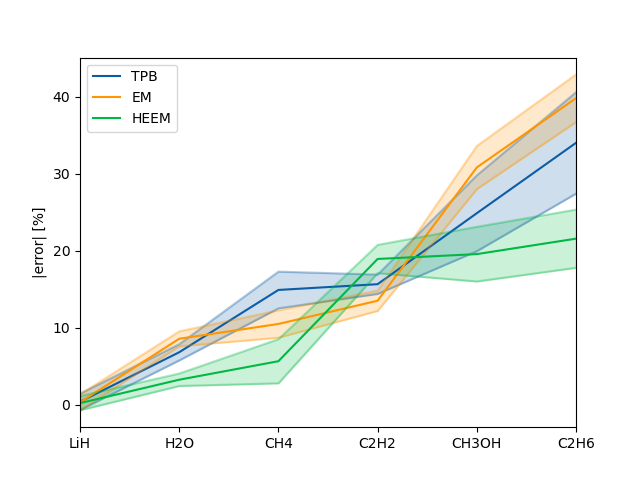

In [4]:
colors = {'TPB': '#0C5DA5', 'HEEM':'#00B945', 'EM': '#FF9500'}
fig, ax = plt.subplots()

x = np.arange(len(molecules))
for method in methods:
    color = colors[method]
    avg = np.abs(data_avg[method] * 100)
    std = data_std[method] * 100
    
    # ax.errorbar(x, avg, yerr=std, fmt='o', label=method, ecolor=color)
    
    line = ax.plot(x, avg, label=method, c=color)
    ax.fill_between(x, avg - std, avg + std, alpha=0.2, color=color)
    for i in range(2):
        ax.plot(x, avg + (-1) ** i * std, ls='-', alpha=0.3, c=color)

# ax.set_yscale('log')
        
ax.set_xlim(0, max(x))
# ax.set_ylim(0, None)

ax.set_ylabel('|error| [%]')

ax.set_xticks(np.arange(len(molecules)))
ax.set_xticklabels(molecules)

ax.legend();